In [1]:
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

import torch
from torchvision import models

from captum.attr import GuidedGradCam, GuidedBackprop, LayerGradCam

# Helper functions
import sys
sys.path.append('../')

from utils.visualise import display_imagenet_output, process_attributions
from utils.datasets import preprocess_imagenet_image

## Load model and image

In [2]:
# Download example image
import sys
sys.path.append('../')

from utils.download import save_image

url = "https://upload.wikimedia.org/wikipedia/commons/a/ae/Sushi_japan.png"
save_image(url, "sushi.png")

(-0.5, 223.5, 223.5, -0.5)

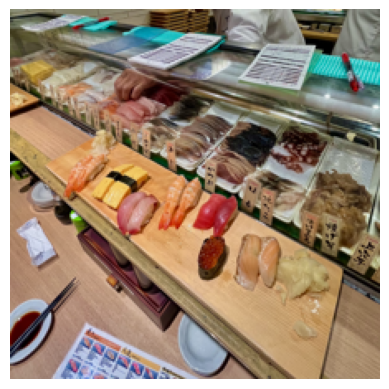

In [2]:
# Load a sample image
img_path = "sushi.png"
img = Image.open(img_path).convert("RGB")

plt.imshow(img)
plt.axis("off")

In [3]:
# Load the pre-trained model (e.g., VGG16)
model = models.vgg16(pretrained=True)

# Set the model to gpu
device = torch.device('mps' if torch.backends.mps.is_built()
                      else 'cuda' if torch.cuda.is_available()
                      else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()
model.zero_grad()

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Preprocess the image
original_img_tensor = preprocess_imagenet_image(img_path)
original_img_tensor = original_img_tensor.to(device)

# Clone tensor to avoid in-place operations
img_tensor = original_img_tensor.clone()
img_tensor.requires_grad_() # Enable gradient tracking

with torch.no_grad():
    predictions = model(img_tensor)

# Decode the output
display_imagenet_output(predictions,n=5)

grocery store 0.2256142646074295
tobacco shop 0.21862675249576569
confectionery 0.17332792282104492
bakery 0.10615035146474838
hotdog 0.04379023611545563


tensor(582, device='mps:0')

## Guided Grad-CAM 

In [5]:
# Specify the target layer and class
target_layer = model.features[29]  # last conv layer in VGG16
target_class = torch.argmax(predictions, dim=1).item() #grocery store, grocery, food market, market

print(f"Target class: {target_class}")

Target class: 582


In [6]:
# Get attributions
ggc = GuidedGradCam(model, target_layer)
ggc_attr = ggc.attribute(img_tensor,
                        target=target_class)

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


Figure saved to /Users/conorosullivan/Documents/XAI/ggc_example.pdf


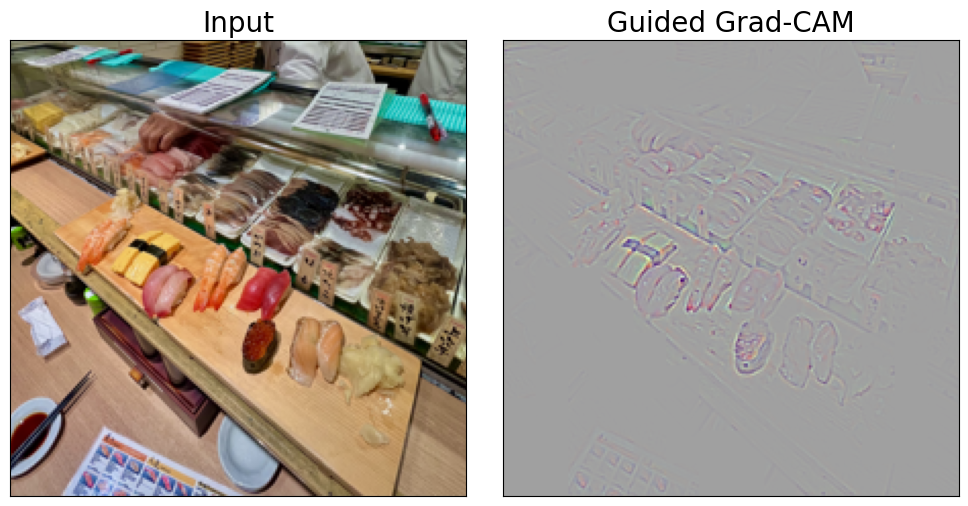

In [7]:
# Process for visualization
ggc_attr = process_attributions(ggc_attr)

# Visualize the results
fig,ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(img)
ax[0].set_title("Input")

ax[1].imshow(ggc_attr)
ax[1].set_title("Guided Grad-CAM")

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [8]:
# Grad-CAM
layer_gc = LayerGradCam(model, target_layer)
gc_attr = layer_gc.attribute(img_tensor, target=target_class)

# Process and upsample
gc_attr_upsampled = torch.nn.functional.interpolate(
    gc_attr, size=(224, 224), mode='bilinear', align_corners=False
)[0][0]
gc_attr_np = gc_attr_upsampled.cpu().detach().numpy()

# Guided Backprop
guided_bp = GuidedBackprop(model)
gb_attr = guided_bp.attribute(img_tensor, target=target_class)

gb_attr = process_attributions(gb_attr)

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


Figure saved to /Users/conorosullivan/Documents/XAI/ggc_combined_example.pdf


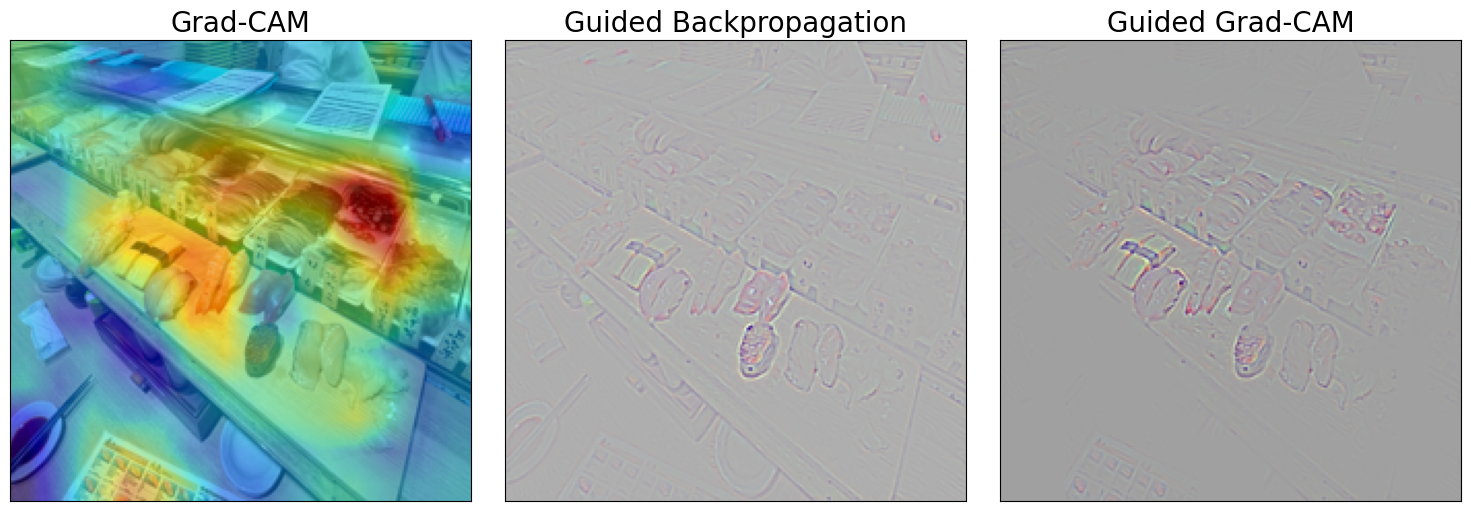

In [9]:
# Visualize
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(img)
ax[0].imshow(gc_attr_np, cmap='jet', alpha=0.5)
ax[0].set_title("Grad-CAM")

ax[1].imshow(gb_attr, cmap='jet')
ax[1].set_title("Guided Backpropagation")

ax[2].imshow(ggc_attr)
ax[2].set_title("Guided Grad-CAM")

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])